In [240]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from scipy import stats
import sklearn
from sklearn.utils import shuffle
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

random_seed = 2 # Set the random seed for all remaining random_state for determinism

## Load data

### load MNIST

In [428]:
data_dir = "/Users/jameschen/Desktop/Cogs118B Intro to ML II/final_project/data"

train_mnist_path = os.path.join(data_dir, "train.csv")
train_df = pd.read_csv(train_mnist_path)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
dtype: int64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

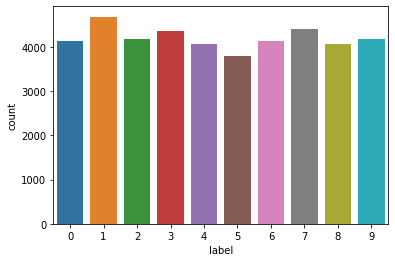

In [429]:
## early explore MNIST data
display(train_df)
display(train_df.groupby("label").size())
sns.countplot(train_df["label"])

In [15]:
# max value is 255 -> need normalization
train_df.iloc[:, 1:].max().max()

255

### load UCI Heart

In [417]:


data_dir = "/Users/jameschen/Desktop/Cogs118B Intro to ML II/final_project/data"

train_heart_path = os.path.join(data_dir, "heart.csv")
train_df = pd.read_csv(train_heart_path)

In [418]:
train_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

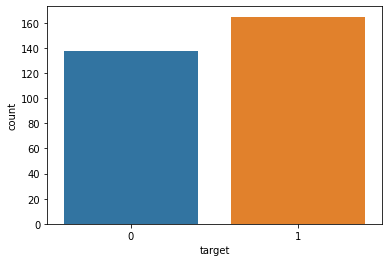

In [235]:
sns.countplot(train_df["target"])

## Preprocess data

(1000, 785)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

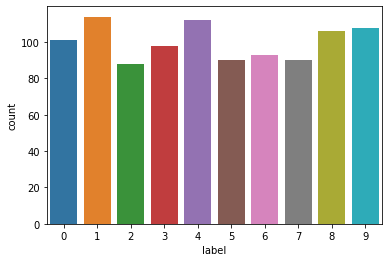

In [431]:
# Sampling only 0 & 1
train_df_s = train_df[(train_df["label"] == 0) | (train_df["label"] == 1) | 
                      (train_df["label"] == 2) | (train_df["label"] == 3)]
train_df_s = train_df.sample(1000, replace=False, random_state=random_seed)
display(train_df_s.shape)
sns.countplot(train_df_s["label"]) # check if still balance

(303, 14)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

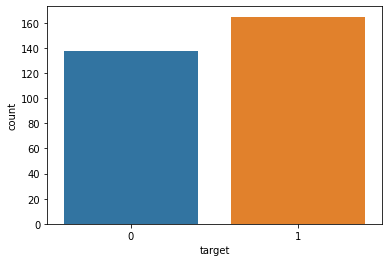

In [411]:
# ### Sampling 
# # train_df_s = train_df.sample(1000, replace=False, random_state=random_seed)
# train_df_s = train_df.sample(frac=1, replace=False, random_state=random_seed)
# display(train_df_s.shape)
# sns.countplot(train_df_s["label"]) # check if still balance

# Sampling 
train_df_s = train_df.sample(frac=1, replace=False, random_state=random_seed)
display(train_df_s.shape)
sns.countplot(train_df_s["target"]) # check if still balance

In [432]:
### extract and normalize features and labels
X_train = np.reshape(train_df_s.iloc[:, 1:].values / 255, (-1, 784))
X_train = X_train - X_train.mean()
Y_train = train_df_s["label"].values

# X_train = np.reshape(train_df_s.iloc[:, :13].values, (-1, 13))
# X_train = StandardScaler().fit_transform(X_train)
# Y_train = train_df_s["target"].values

print(X_train.shape, Y_train.shape)

(1000, 784) (1000,)


In [433]:
# dimension reduction
pca = PCA(n_components=0.90, svd_solver='full')
pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
print(X_train_pca.shape)

## get the 2 principal comp for vis
pca_2 = PCA(n_components=2)
pca_2 = pca_2.fit(X_train)
X_train_pca_2 = pca_2.transform(X_train)
print(X_train_pca_2.shape)

## get the 3 principal comp for vis
pca_3 = PCA(n_components=3)
pca_3 = pca_3.fit(X_train)
X_train_pca_3 = pca_3.transform(X_train)
print(X_train_pca_3.shape)

(1000, 79)
(1000, 2)
(1000, 3)


## Method

cluster alg + metric

Metric:   
SC: Silhouette Coefficient

### K-Means

In [442]:
def run_cluster_alg(X, cluster="kmeans", metric="SC", K_range=(10,), iteration=5, debug=False, vis=False):
    """
    Core alg to run each cluster and calculate metrix
    Arg:
        cluster_func: some cluster scheme
    """
    metric_for_K_list = []
    label_for_K_list = []
    for K in (K_range): #tqdm.tqdm
        metric_iter_list = []
        label_iter_list = []
        for i in range(iteration): 
            # For each K and each iter, compute label and metrics
            if cluster == "kmeans":
                kmeans = KMeans(n_clusters=K, n_init=1).fit(X)
                Y_pred = kmeans.labels_
            elif cluster == "kmeans3":
                kmeans = KMeans(n_clusters=K, n_init=3).fit(X)
                Y_pred = kmeans.labels_
            elif cluster == "kmeans5":
                kmeans = KMeans(n_clusters=K, n_init=5).fit(X)
                Y_pred = kmeans.labels_
            elif cluster == "kmeans10":
                kmeans = KMeans(n_clusters=K, n_init=10).fit(X)
                Y_pred = kmeans.labels_
            elif cluster == "MiniBatchKMeans":
                kmeans = MiniBatchKMeans(n_clusters=K, n_init=1, init="random").fit(X)
                Y_pred = kmeans.labels_
            elif cluster == "xxx":
                pass # TODO
            
            if metric == "SC":
                pred_metric = metrics.silhouette_score(X, Y_pred)
            elif metric == "consistency":
                pred_metric = 0 ## null value, decide later

            metric_iter_list.append(pred_metric)
            label_iter_list.append(Y_pred)
            
        if metric == "consistency":
            mode_label = stats.mode(label_iter_list).mode.astype(int).flatten()
            metric_iter_list = []
            for label in label_iter_list:
#                 fake_range_index = metrics.rand_score(mode_label, label)
                fake_range_index = metrics.adjusted_rand_score(mode_label, label)
                metric_iter_list.append(fake_range_index)
            metric_for_K_list.append(-np.var(metric_iter_list)) # max -var
            label_for_K_list.append(label_iter_list[np.argmax(metric_iter_list)])
            
            if debug:
                print(mode_label, label_iter_list)
        else:
            metric_for_K_list.append(np.max(metric_iter_list))
            label_for_K_list.append(label_iter_list[np.argmax(metric_iter_list)])
            
        if vis: # assume X_train_pca_2 is available
            curr_var = metric_for_K_list[-1]
            curr_var = np.exp(curr_var)*10
            print(f"--- Visualize K = {K}, var={curr_var} ------")
            fig, ax = plt.subplots(1, iteration, figsize=(4*iteration, 4.25), constrained_layout=True)
            for ax_ind in range(iteration):
                for current_K in range(K):
                    ind = (label_iter_list[ax_ind] == current_K)
                    ax[ax_ind].scatter(X_train_pca_2[ind,0], X_train_pca_2[ind,1], label=f"cluster {current_K}")
                    ax[ax_ind].legend()
            plt.show()
#             plot_labeled_scatter(Y_pred, K, X_train_pca_2)
            
    best_K_ind = np.argmax(metric_for_K_list)
    best_K = K_range[best_K_ind]
    best_metric = metric_for_K_list[best_K_ind]
    best_label = label_for_K_list[best_K_ind]
    
    if debug:
        print(metric_for_K_list, label_for_K_list)
    return best_K, best_metric, best_label, metric_for_K_list

## Evaluation

In [348]:
# get accuracy
K_range = range(2,15)
num_runs = 20

K_list = []
rand_list = []
for i in tqdm.tqdm(range(num_runs)):
#     K_pred, metric_pred, Y_pred, metric_list = run_cluster_alg(X_train_pca, cluster="kmeans", metric="SC", K_range=K_range, iteration=10)
#     K_pred, metric_pred, Y_pred, metric_list = run_cluster_alg(X_train_pca, cluster="kmeans3", metric="SC", K_range=K_range, iteration=10)

#     K_pred, metric_pred, Y_pred, metric_list = run_cluster_alg(X_train_pca, cluster="kmeans", metric="consistency", 
#                                                                K_range=K_range, iteration=10, vis=False)
#     K_pred, metric_pred, Y_pred, metric_list = run_cluster_alg(X_train_pca, cluster="kmeans3", metric="consistency", 
#                                                                K_range=K_range, iteration=10, vis=False)
#     K_pred, metric_pred, Y_pred, metric_list = run_cluster_alg(X_train_pca, cluster="kmeans5", metric="consistency", 
#                                                                K_range=K_range, iteration=10, vis=False)
#     K_pred, metric_pred, Y_pred, metric_list = run_cluster_alg(X_train_pca, cluster="kmeans10", metric="consistency", 
#                                                                K_range=K_range, iteration=10, vis=False)
    K_pred, metric_pred, Y_pred, metric_list = run_cluster_alg(X_train_pca, cluster="MiniBatchKMeans", metric="consistency", 
                                                               K_range=K_range, iteration=15, vis=False)
    
    K_list.append(K_pred)
    rand_list.append(metrics.rand_score(Y_train, Y_pred))

accuracy = (np.array(K_list) == np.unique(Y_train).size).mean()
mean_rand = np.mean(rand_list)
print(accuracy, mean_rand)
print(K_list, rand_list)

100%|██████████| 20/20 [00:38<00:00,  1.90s/it]

0.0 0.5454789849845912
[12, 12, 12, 13, 14, 8, 13, 13, 14, 12, 12, 12, 14, 12, 9, 8, 8, 14, 10, 13] [0.552313509496645, 0.5437676217952921, 0.5486634756190851, 0.5470242388477259, 0.5485979061482307, 0.5571437938495837, 0.5351124516425152, 0.5381942167726707, 0.5348938867396673, 0.5286210740279326, 0.5573842152427163, 0.5396804581120364, 0.5298450374838808, 0.5413634078639652, 0.5538216073262956, 0.5590015955237908, 0.5520293751229428, 0.5323366773763469, 0.5584770397569558, 0.5513081109435447]


--- Visualize K = 2, var=8.77570384624866 ------


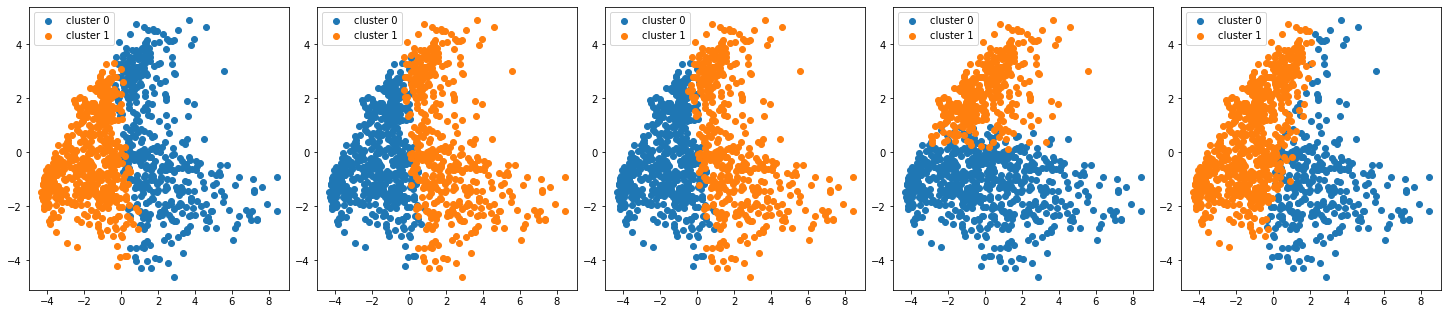

--- Visualize K = 3, var=9.993849379743372 ------


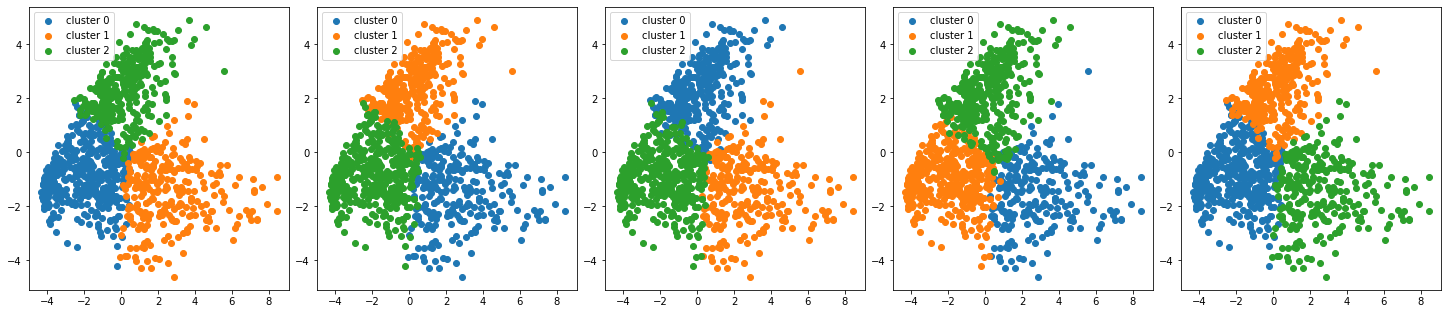

--- Visualize K = 4, var=9.838154257210977 ------


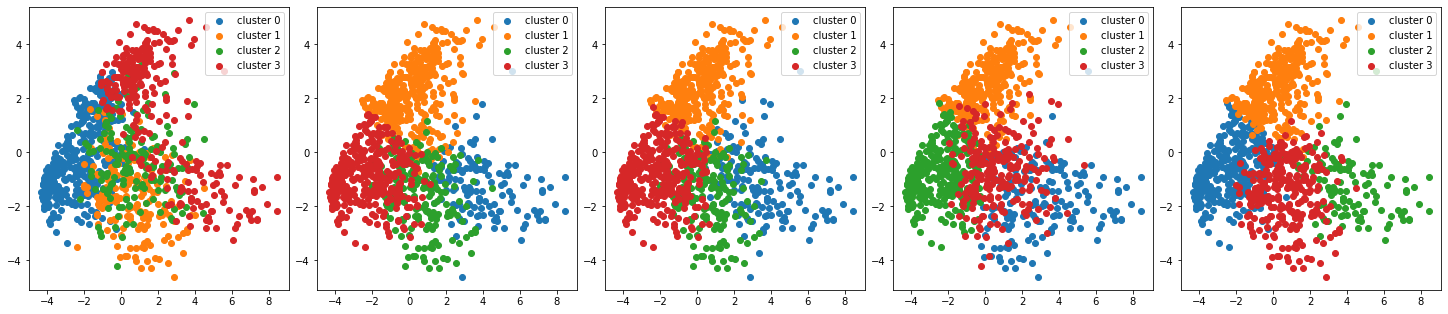

--- Visualize K = 5, var=9.929587666185013 ------


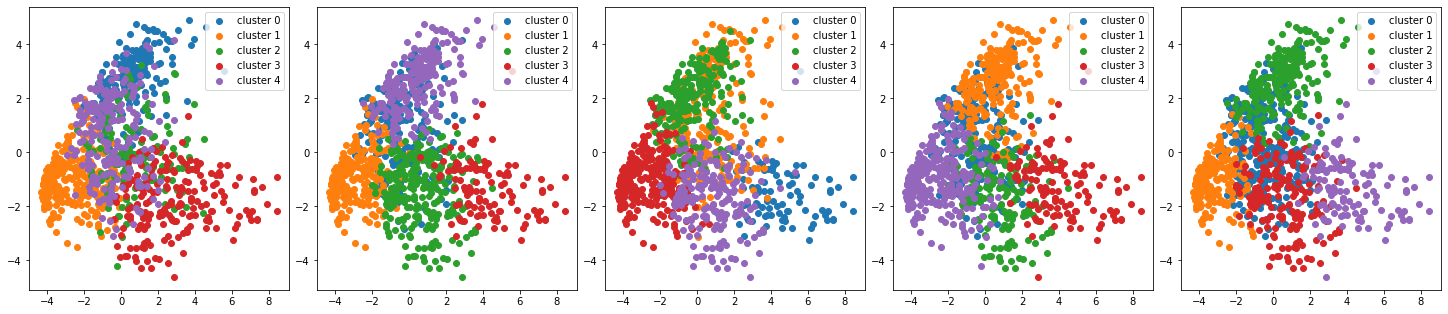

--- Visualize K = 6, var=9.936092024534233 ------


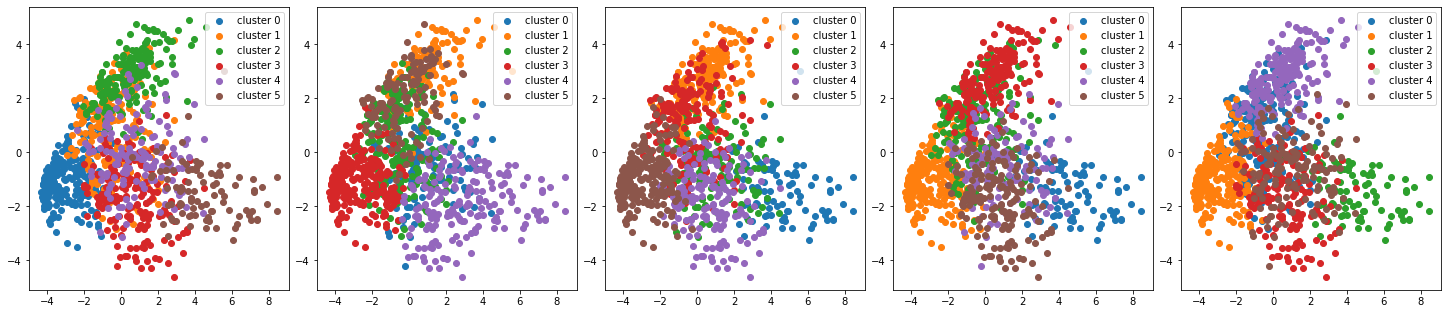

--- Visualize K = 7, var=9.995294748820761 ------


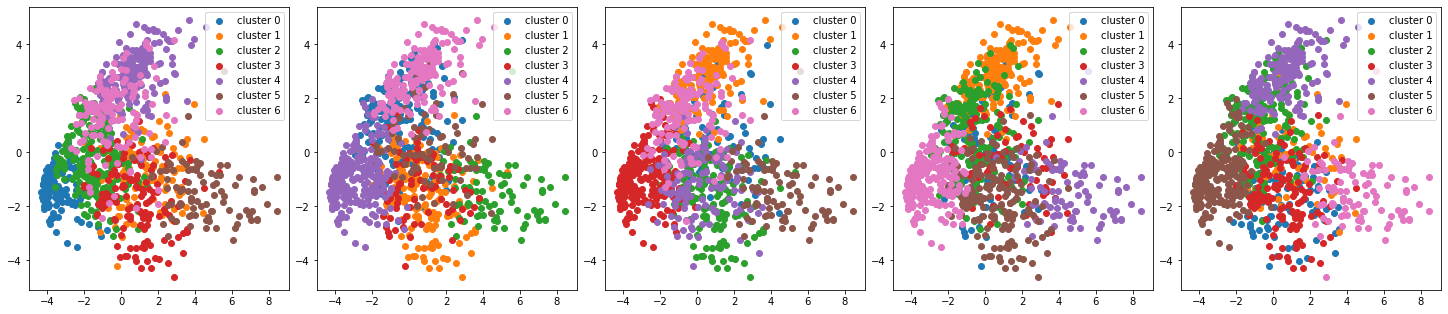

--- Visualize K = 8, var=9.991757853828258 ------


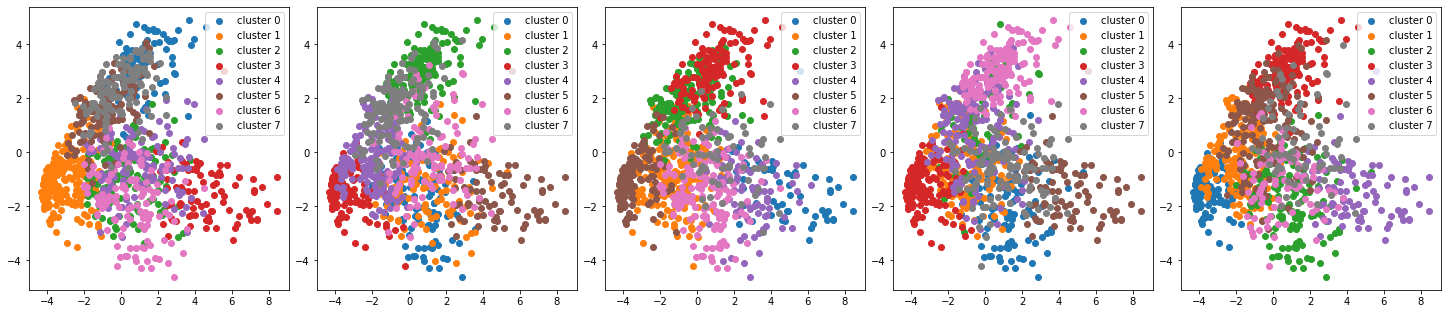

--- Visualize K = 9, var=9.995934877040767 ------


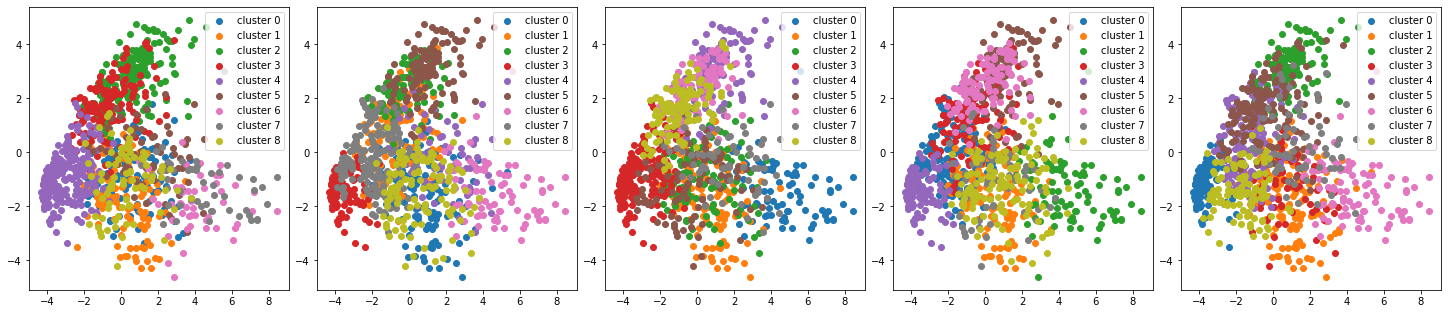

--- Visualize K = 10, var=9.983451680962565 ------


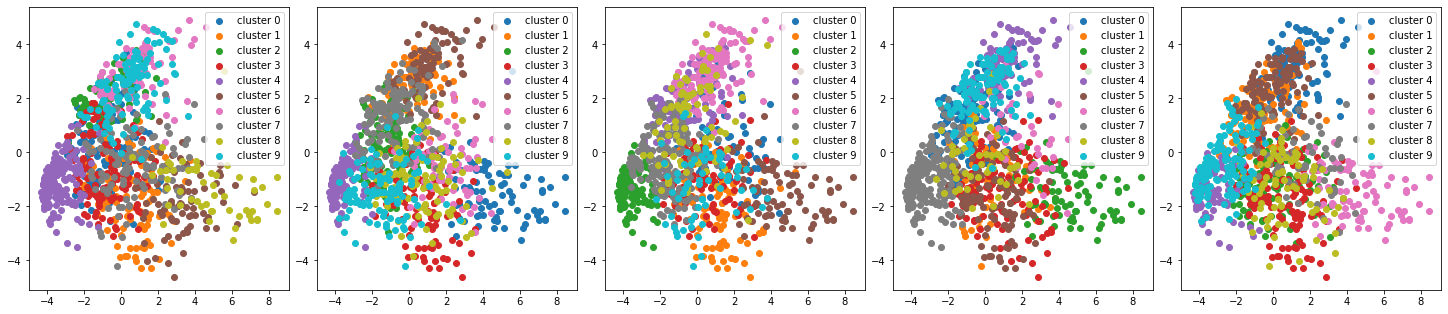

--- Visualize K = 11, var=9.996318296077689 ------


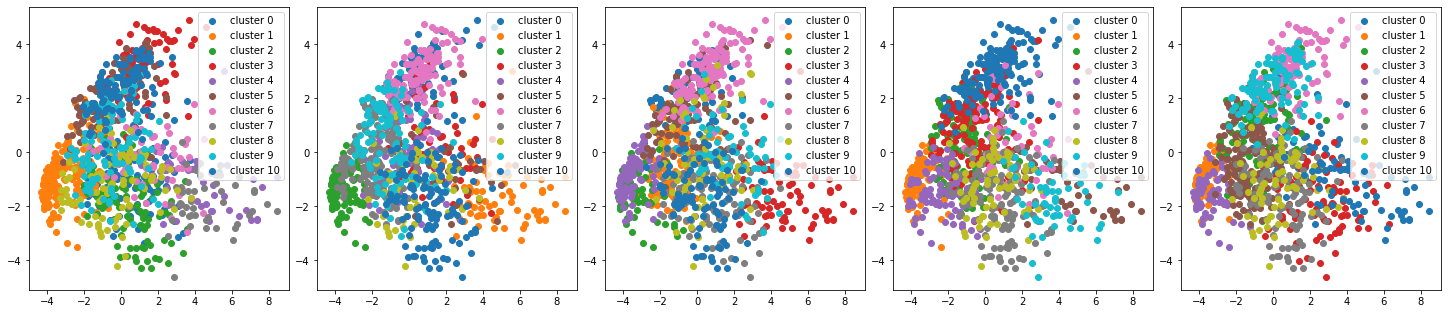

--- Visualize K = 12, var=9.981596897206122 ------


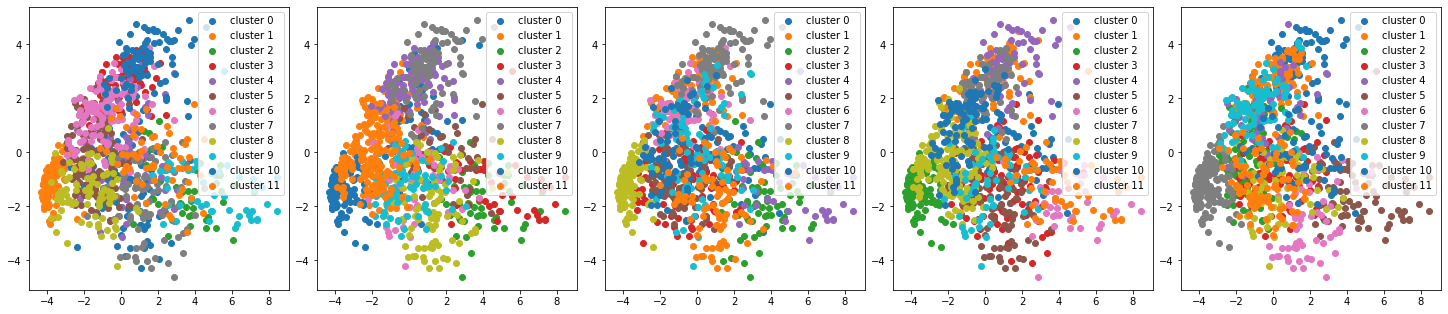

--- Visualize K = 13, var=9.97406492697706 ------


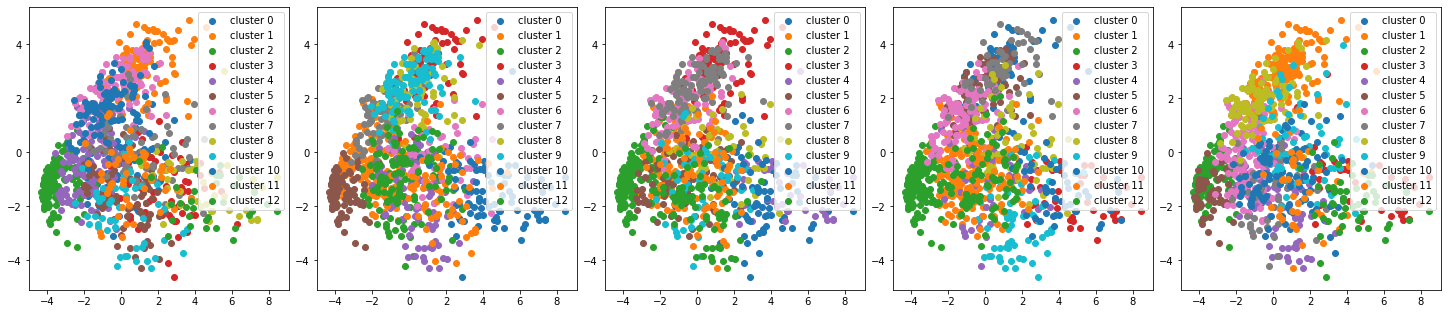

--- Visualize K = 14, var=9.996930242892667 ------


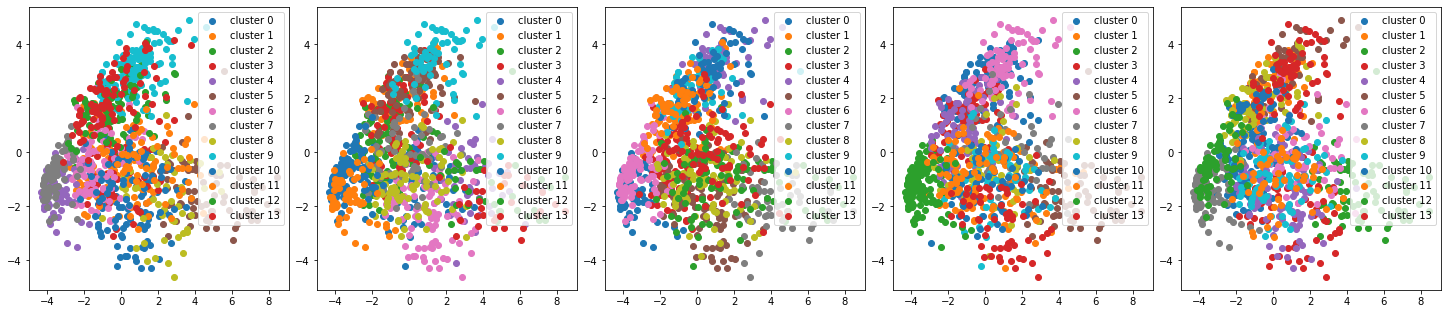

14 -0.0003070228374214637


In [443]:
# K_range = [2,3,4,5,7,10,13,15]
# K_range = [2,3,4, 5,7]
# K_range = [4]
K_range = range(2,15)
# K_pred, metric_pred,Y_pred, metric_list = run_cluster_alg(X_train_pca, cluster="kmeans", metric="SC", K_range=K_range, iteration=10)
# K_pred, metric_pred, Y_pred, metric_list = run_cluster_alg(X_train_pca, cluster="kmeans", metric="consistency", K_range=K_range, iteration=5)

# debug
K_pred, metric_pred, Y_pred, metric_list = run_cluster_alg(X_train_pca, cluster="kmeans", metric="consistency", 
                                                           K_range=K_range, iteration=5, vis=True)
# K_pred, metric_pred, Y_pred, metric_list = run_cluster_alg(X_train_pca, cluster="MiniBatchKMeans", metric="consistency", 
#                                                            K_range=K_range, iteration=15, vis=True)
print(K_pred, metric_pred)

In [264]:
display({
    "test rand score":metrics.rand_score(Y_train, Y_pred), 
    "predicted K": K_pred,
    "predicted_metric": metric_pred,
    "num_gt_digits": np.unique(Y_train).size,
    "num_pred_digits": np.unique(Y_pred).size
}
)

{'test rand score': 0.6976810263807838,
 'predicted K': 2,
 'predicted_metric': 0.17656069002310784,
 'num_gt_digits': 2,
 'num_pred_digits': 2}

{2: 0.09806957371895417, 3: 0.06176599534385198, 4: 0.07089737673201182, 5: 0.07802105398290198, 6: 0.07845637863249336, 7: 0.08205012072320403, 8: 0.08830704969728474, 9: 0.0856369568229915, 10: 0.08866412613729982, 11: 0.08545792466134843, 12: 0.07643972454514007, 13: 0.0771045087029672, 14: 0.07738165691814504}


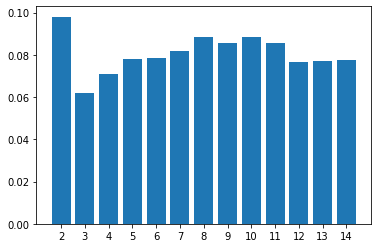

In [225]:
plt.bar(range(len(K_range)), metric_list)
plt.xticks(range(len(K_range)), K_range)
print({k_:m_ for k_, m_ in zip(K_range, metric_list)})

In [161]:
# Goal: K = 10: (0.8794166221644732, 0.3606819994245816)
# kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train_pca)
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train)
print(kmeans.labels_.shape)
(metrics.rand_score(Y_train, kmeans.labels_), metrics.adjusted_rand_score(Y_train, kmeans.labels_))

(42000,)


(0.8795706360355519, 0.36144300671286056)

## Visualization

In [408]:
def plot_labeled_scatter(Y_pred, K_pred, X_train_pca_2, save_name=""):
    plt.figure(figsize=(7,6), dpi=200) 
    ax = plt.subplot()
    # Y_pred = kmeans.labels_
    # K_pred = 10
    for current_K in range(K_pred):
        ind = (Y_pred == current_K)
        ax.scatter(X_train_pca_2[ind,0], X_train_pca_2[ind,1], label=f"cluster {current_K}")
        ax.legend()
    if save_name != "":
        plt.savefig(os.path.join("plot", save_name))
    else:
        plt.show()

def plot_3d_labeled_scatter(Y_pred, K_pred, X_train_pca_2, save_name="", dpi=500):
    plt.figure(figsize=(7,7), dpi=dpi) 
    ax = plt.subplot(111, projection='3d')
    for current_K in range(K_pred):
        ind = (Y_pred == current_K)
        ax.scatter(X_train_pca_3[ind,0], X_train_pca_3[ind,1], X_train_pca_3[ind,2], marker=".", label=f"cluster {current_K}")
        ax.legend()
    if save_name != "":
        plt.savefig(os.path.join("plot", save_name))
    else:
        plt.show()

In [368]:
X_train_pca_2.shape, Y_train.shape

((303, 2), (303,), (303,))

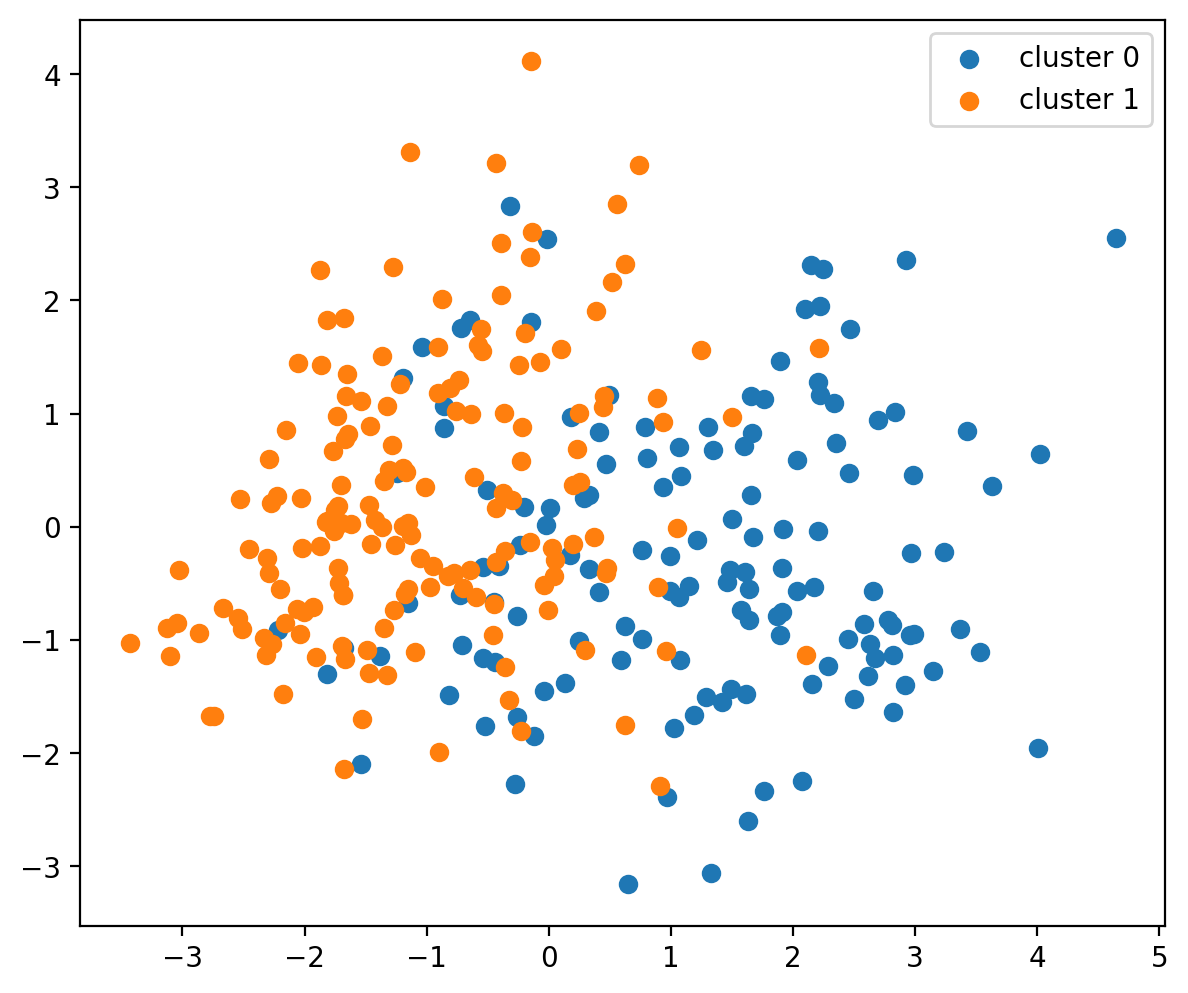

In [414]:
# save_name="2d_kmeans_10"
save_name="2d_heart_2"
plot_labeled_scatter(Y_train, 2, X_train_pca_2, save_name=save_name)

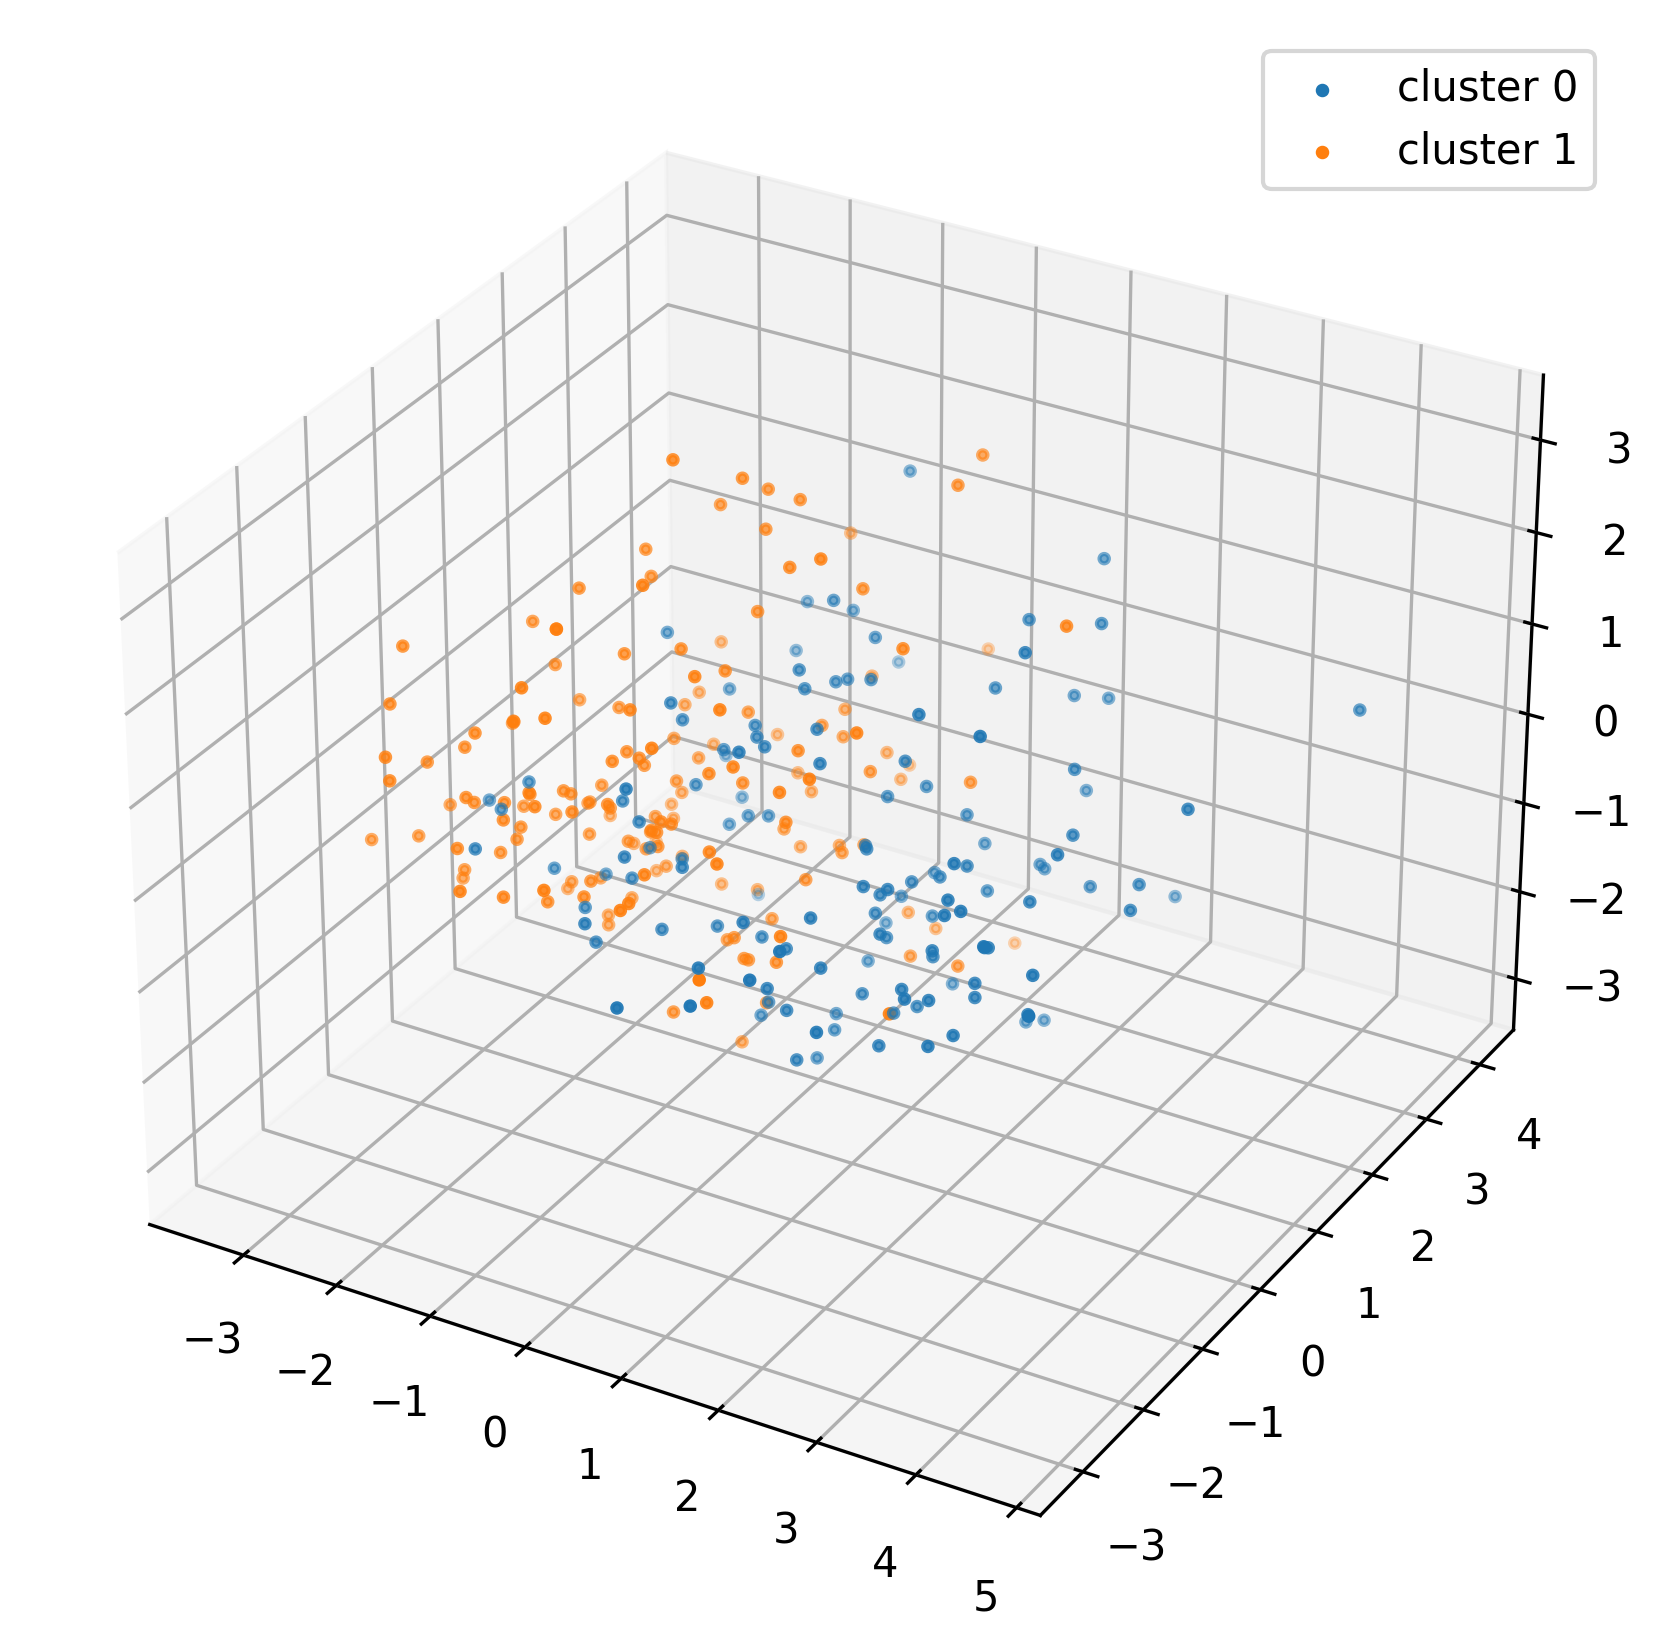

In [386]:
save_name="3d_heart_2"
plot_3d_labeled_scatter(Y_train, 2, X_train_pca_3, save_name=save_name, dpi=300)